In [30]:
# import packages
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection as train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef

# import modules
import classify

# reload modules
importlib.reload(classify)

<module 'classify' from 'c:\\Users\\erica\\OneDrive - ETH Zurich\\Exchange\\Machine Learning\\CS349---Group8\\Final Project\\classify.py'>

## 1 - Dataset

In [2]:
# read in data
data = pd.read_csv('./Data/ai4i2020.csv')
features = ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
numeric_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
categorical_features = ['Type']
labels = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
display(data.head(3))
print('Shape of data:', data.shape)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0


Shape of data: (10000, 14)


### Exploratory Data Analysis

#### General Statistics

In [3]:
print('Numeric Feature Columns')
feature_stats = data[numeric_features].describe().drop(['count', '25%', '50%', '75%'])
display(feature_stats)

print('Label Columns')
label_stats = data[labels].describe().drop(['count', 'std', 'min', 'max', '25%', '50%', '75%']).rename(index={'mean': 'Failure Rate'})
label_stats.loc['Failure Type Proportion'] = label_stats.loc['Failure Rate'] / label_stats.loc['Failure Rate', 'Machine failure']
display(label_stats)

Numeric Feature Columns


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
mean,300.004930,310.005560,1538.776100,39.986910,107.951000
std,2.000259,1.483734,179.284096,9.968934,63.654147
min,295.300000,305.700000,1168.000000,3.800000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000


Label Columns


,Machine failure,TWF,HDF,PWF,OSF,RNF
Failure Rate,0.0339,0.004600,0.011500,0.009500,0.009800,0.001900
Failure Type Proportion,1.0000,0.135693,0.339233,0.280236,0.289086,0.056047


#### Visualizations

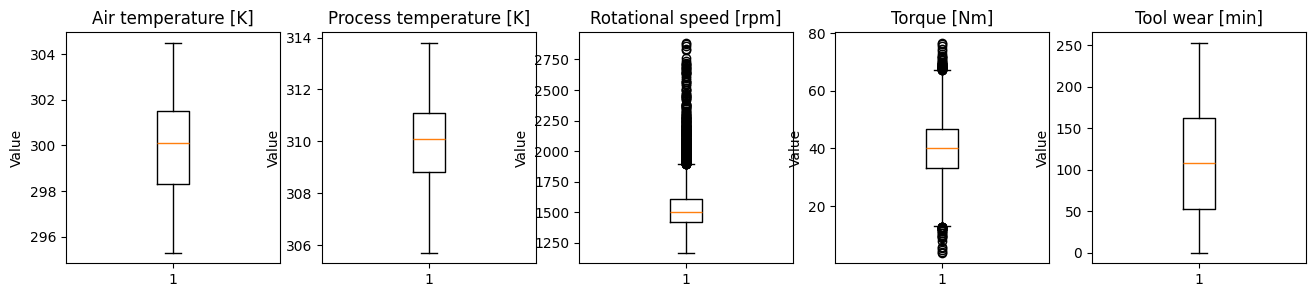

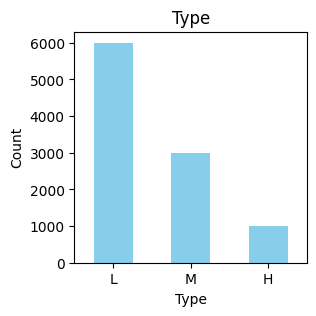

In [4]:
fig, axes = plt.subplots(1, 5, figsize=(16, 3))
for idx in range(len(numeric_features)):
    axes[idx].boxplot(data[numeric_features[idx]])
    axes[idx].set_title(numeric_features[idx])
    axes[idx].set_ylabel('Value')
plt.show()

fig, ax = plt.subplots(figsize=(3, 3))
data[categorical_features[0]].value_counts().plot(kind='bar', ax=ax, color='skyblue')
ax.set_title(categorical_features[0])
ax.set_xlabel('Type')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=0)
plt.show()



#### Correlations

In [5]:
print('Correlation Matrix for Features')
data[numeric_features].corr()

Correlation Matrix for Features


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
Air temperature [K],1.000000,0.876107,0.022670,-0.013778,0.013853
Process temperature [K],0.876107,1.000000,0.019277,-0.014061,0.013488
Rotational speed [rpm],0.022670,0.019277,1.000000,-0.875027,0.000223
Torque [Nm],-0.013778,-0.014061,-0.875027,1.000000,-0.003093
Tool wear [min],0.013853,0.013488,0.000223,-0.003093,1.000000


### Data Restructuring
Multi-label versus multi-class classification?

In [6]:
def determine_failure_mode(event, specify_multiple):
    failure_modes = [failure for failure in labels[1:] if event[failure] == 1]
    if not failure_modes:
        return 'No failure'
    elif specify_multiple:
        return '_'.join(failure_modes)
    else:
        return failure_modes[0] if len(failure_modes) == 1 else 'Multiple failures'

In [7]:
data['Failure Mode'] = data.apply(lambda event: determine_failure_mode(event = event, specify_multiple = False), axis=1)
labels.append('Failure Mode') if 'Failure Mode' not in labels else None
data['Failure Mode'].value_counts()

Failure Mode
No failure           9652
HDF                   106
PWF                    80
OSF                    78
TWF                    42
Multiple failures      24
RNF                    18
Name: count, dtype: int64

### Train Test Split

In [11]:
# problem: hardly any RNF failures

X_remainder, X_test, y_remainder, y_test = train_test_split.train_test_split(data[features], data[labels], test_size=0.1, stratify=data['Failure Mode'], random_state=42)
X_train, X_val, y_train, y_val = train_test_split.train_test_split(X_remainder, y_remainder, test_size=0.2, stratify=y_remainder['Failure Mode'], random_state=42)
print('Shape of training data:', X_train.shape)
print('Shape of validation data:', X_val.shape)
print('Shape of test data:', X_test.shape)
display(X_train.head(3), y_train.head(3))

Shape of training data: (7200, 8)
Shape of validation data: (1800, 8)
Shape of test data: (1000, 8)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
7604,7605,L54784,L,300.4,311.3,1639,34.6,24
4593,4594,L51773,L,303.0,311.2,1409,41.9,98
7976,7977,H37390,H,301.2,312.4,1395,47.8,90


,Machine failure,TWF,HDF,PWF,OSF,RNF,Failure Mode
7604,0,0,0,0,0,0,No failure
4593,0,0,0,0,0,0,No failure
7976,0,0,0,0,0,0,No failure


## 2 - Classifiers

### Naive Classifier
Baseline 1

In [31]:
importlib.reload(classify)
naive_labels = classify.naive_classify(X_test)
naive_accuracy = accuracy_score(naive_labels, y_test['Failure Mode'])
naive_precision = precision_score(naive_labels, y_test['Failure Mode'], average='weighted')
naive_recall = recall_score(naive_labels, y_test['Failure Mode'], average='weighted')
naive_f1 = f1_score(naive_labels, y_test['Failure Mode'], average='weighted')
naive_confusion = confusion_matrix(naive_labels, y_test['Failure Mode'])
naive_matthews = matthews_corrcoef(naive_labels, y_test['Failure Mode'])

print('Naive Classifier')
print('Accuracy:', naive_accuracy)
print('Precision:', naive_precision)
print('Recall:', naive_recall)
print('F1 Score:', naive_f1)
print('Confusion Matrix:')
print(naive_confusion)
print('Matthews Correlation Coefficient:', naive_matthews)

Naive Classifier
Accuracy: 0.965
Precision: 1.0
Recall: 0.965
F1 Score: 0.9821882951653944
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [ 11   2 965   8   8   2   4]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]
Matthews Correlation Coefficient: 0.0


c:\Users\erica\OneDrive - ETH Zurich\Exchange\Machine Learning\CS349---Group8\venv_cs349\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Decision Tree
Baseline 2

### k-NN

### Neural Network

## 3 - Comparison